In [1]:
# 1. Module Import 
import numpy as np                              # 선형대수를 위한 NumPy 라이브러리 불러오기
import matplotlib.pyplot as plt                 # 데이터 시각화를 위한 Matplotlib 라이브러리 불러오기

import torch                                    # PyTorch 라이브러리 불러오기 (딥러닝 프레임워크)
import torch.nn as nn                           # 신경망 모델 생성을 위한 모듈 불러오기
import torch.nn.functional as F                 # 활성화 함수 등 신경망 관련 주요 함수들 불러오기
from torchvision import transforms, datasets    # 이미지 데이터 전처리 및 데이터셋 다운로드를 위한 torchvision 모듈 불러오기

In [2]:
# 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 

if torch.cuda.is_available():                  # 만약 CUDA(GPU)가 사용 가능하면
    DEVICE = torch.device('cuda')              # 장치를 GPU로 설정
else: 
    DEVICE = torch.device('cpu')              # 그렇지 않으면 장치를 CPU로 설정

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)  # 사용 중인 PyTorch 버전과 선택된 장치 출력



Using PyTorch version: 2.8.0+cu126 Device: cuda


In [3]:
# 3.하이퍼 파라미터 정의 
BATCH_SIZE = 32
EPOCHS = 10


In [4]:
# 4. 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기(Train set, Test set 분리하기)

data_transforms = {                          # 데이터의 역할에 따라 데이터 전처리 및 증강 적용 하기 위한 객체를 담은 딕셔너리 변수          
    'train' : transforms.Compose([           # 불러오는 이미지 데이터에 전처리 및 Augmentation을 다양하게 적용할 떄 이용하는 메서드  
        transforms.RandomResizedCrop(224),   # 이미지의 사이즈는 224 변경되는 이미지 픽셀 값은 랜덤 선택
        transforms.RandomHorizontalFlip(),   # 이미지를 50%확률로 좌우 반전 
        transforms.ToTensor(),               # 0~1사이의 값으로 정규화하며 딥러닝 모델의 Input으로 이용될 수 있또록 Tensor형태로 변환
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])  # Tensor형태로 변환된 이미지에 또다른 정규화 진행 
    ]),
    'val' : transforms.Compose([             # 불러오는 이미지 데이터에 전처리 및 Augmentation을 다양하게 적용할 떄 이용하는 메서드
        transforms.CenterCrop(224),          # 이미지 중앙을 기준으로 224*224크기로 잘라내 사이즈를 변경
        transforms.Resize(256),              # 이미지의 사이즈를 256*256 크기로 사이즈를 변경
        transforms.ToTensor(),               # 0~1사이의 값으로 정규화하며 딥러닝 모델의 Input으로 이용될 수 있또록 Tensor형태로 변환
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])  # Tensor형태로 변환된 이미지에 또다른 정규화 진행 
    ])
}

# 지정한 경로에 저장한 이미지 데이터를 불러와 학습용 데이터, 검증 데이터 종류에 따라 미리 정의해 둔 데이터 전처리 각각 적용하기 위해 딕셔너리 형태 사용 
image_datasets = {x: datasets.ImageFolder(f"../data/hymenoptera_data/{x}",data_transforms[x])  
                  for x in ['train','val']} 

# 불러온 이미지를 미니 배치단위로 구분, 학습용, 검증용 데이터 종류에 따라 각각 적용하기 위해 딕셔너리 형태 사용
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],   
               batch_size = BATCH_SIZE,
               num_workers=0,                                   # 멀티 프로세싱으로 진행하지 않으면 0
               shuffle=True)                                    # 데이터 순서를 섞음         
               for x in ['train','val']}          

In [ ]:
# 5. 데이터 확인하기 (1)
for images, labels in dataloaders['train']:
    print(labels.min(), labels.max())  # 0, 1 이어야 함
    break

tensor(0) tensor(1)


In [ ]:
# 6. 데이터 확인하기 (2)
for (x_train, y_train) in dataloaders['train']:                         # 학습용 데이터 로더에서 배치 단위로 데이터를 가져옴
    print('x_train:', x_train.size(), 'type:', x_train.type())  # 입력 이미지 텐서의 크기와 자료형 출력
    print('y_train:', y_train.size(), 'type:', y_train.type())  # 정답 라벨 텐서의 크기와 자료형 출력
    break                                                       # 첫 번째 배치만 확인하고 반복 종료


x_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.62352943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the v

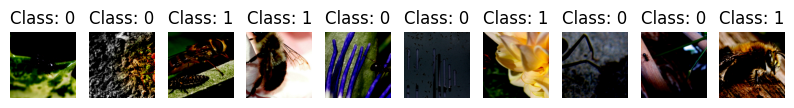

In [ ]:
# 7. 데이터 확인하기 (3)
pltsize = 1                                             # 출력 이미지 크기 설정
plt.figure(figsize=(10 * pltsize, pltsize))             # 전체 그림 크기 설정 (가로로 10개 이미지)

for i in range(10):                                     # 처음 10개 이미지에 대해 반복
    plt.subplot(1, 10, i + 1)                           # 1행 10열의 서브플롯 중 i번째 위치
    plt.axis('off')                                     # 축(좌표) 숨기기
    plt.imshow(np.transpose(x_train[i],(1,2,0)))        # (C,H,W) → (H,W,C)로 변환 후 이미지 출력
    plt.title('Class: ' + str(y_train[i].item()))       # 해당 이미지의 클래스(숫자 라벨) 표시

In [ ]:
# 8. 파이토치 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정하기
import torchvision.models as models
model = models.resnet18(pretrained=False)        # 사전학습되지 않은 resnet18의 파라미터 값을 gpu로 이동
num_ftrs = model.fc.in_features                   # 완전연결층 입력값의 크기를 저장
model.fc = nn.Linear(num_ftrs,2)                  # 완전연결층을 분류하고자하는 벌과 개미 2개의 클래스로 분류할 수 있게 수정
model = model.cuda()                              # 모델의 파라미터를 GPU에서 계산할 수 있게 이동

/home/centa/miniconda3/envs/firstproject/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/centa/miniconda3/envs/firstproject/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# 9. Optimizer(최적화 알고리즘), Objective Function(손실 함수)설정 
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)    # 모델의 파라미터를 Adam 최적화 알고리즘으로 업데이트하도록 설정 (학습률 0.001)
criterion = nn.CrossEntropyLoss()                             # 분류 문제이기 때문에 손실함수로 CrossEntropyLoss 사용 

print(model)                                                  # 모델 구조를 출력 — 각 층의 구성과 파라미터 정보를 확인할 수 있음

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 10. 불러온 특정 모델에 대해 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의

def train(Epoch,model, train_loader, optimizer, log_interval):       
    model.train()                                                # 모델을 학습 상태로 지정 
    for batch_idx, (image, label) in enumerate(train_loader):    # 학습 데이터를 배치 묶음 단위로 차례대로 학습
        image=image.to(DEVICE)                                   # 지정한 학습 장치(CPU or GPU)에 이미지 데이터 할당
        label=label.to(DEVICE)                                   # 지정한 학습 장치(CPU or GPU)에 레이블 데이터 할당
        optimizer.zero_grad()                                    # 과거 학습으로 계산된 최적화 함수의 Loss, Gradient 초기화 
        output = model(image)                                    # 할당된 이미지 데이터를 모델의 Input으로 이용해 Output을 계산 
        loss = criterion(output,label)                           # 계산된 Output과 실제 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 Loss 값 계산
        loss.backward()                                          # 계산된 Loss 결과값을 바탕으로 역전파 시켜 계산된 Gradient 값을 각 파라미터(가중치)에 할당
        optimizer.step()                                         # 각 파라미터 별로 할당된 Gradient 값을 이용해 파라미터 값을 업데이트
        
        if batch_idx % log_interval == 0:                        # 에포크 당 배치 데이터 별 학습 결과 Loss값 출력
            print(f"Train Epoch: {Epoch} [{batch_idx*len(image)}/{len(train_loader.dataset)}({100. * batch_idx / len(train_loader):.0f}%)]\tTrain Loss: {loss.item():.6f}")
        

In [ ]:
# 11. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

def evaluate(model, test_loader):
    model.eval()     # 모델을 평가 상태로 지정
    test_loss = 0    # 테스트 데이터를 이용해 Loss 값을 계산하기 위해 임시로 0으로 지정
    correct = 0      # 학습 중이거나 완료된 모델이 올바른 Class로 분류한 경우를 세기 위해 임시로 0으로 지정 
    
    with torch.no_grad():                    # 모델을 평가하는 단계에서 계산된 Gradient값이 파라미터 값을 업데이트 하지 못하게 억제 
        for image, label in test_loader:     # 테스트 데이터에 배치 형태로 저장되어 있는 이미지,라벨 데이터를 반복문을 통해 차례대로 접근  
            image = image.to(DEVICE)         # 지정한 학습 장치(CPU or GPU)에 이미지 데이터 할당 
            label = label.to(DEVICE)         # 지정한 학습 장치(CPU or GPU)에 레이블 데이터 할당
            output = model(image)            # 할당된 이미지 데이터를 모델의 Input으로 이용해 Output을 계산 
            test_loss += criterion(output, label).item()     # 계산된 Output과 실제 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 Loss 값 계산
            prediction = output.max(1,keepdim = True)[1]     # 모델의 10개의 클래스의 대한 확률값을 나타낸 Output 값 중 가장 큰 값인 위치가 예측값이라 판단 
            correct += prediction.eq(label.view_as(prediction)).sum().item() # 예측값과 실제 레이블값을 비교해 맞으면 correct에 더해 맞힌 횟수 저장 
            
    test_loss /= len(test_loader.dataset)                    # 현재까지 계산된 test_loss의 값을 테스트 데이터내의 배치 개수만큼 나눠 평균 Loss를 게산 
    test_accuracy =100. * correct / len(test_loader.dataset) # 테스트 데이터중 몇 개를 맞췄는지 정확도 계산 
    return test_loss, test_accuracy                          # 함수 결과로 반환 

In [ ]:
# 12. 미리 학습되지 않은 ResNet18 학습을 실행하며, Train, Test set의 Loss 및 Test set Accuracy 확인하기
for Epoch in range(1,EPOCHS+1):       #  학습 진행시 전체 데이터셋을 이용하는 횟수만큼 반복문 실행
    train(Epoch,model, dataloaders["train"], optimizer, log_interval = 5)  # 정의한 Train (모델 학습 함수) 실행 
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])                # 정의한 Evaulate (모델 평가 함수) 실행하여 검증 데이터셋에 대한 Loss값과 정확도를 저장
    print(f"\n[EPOCH]: {Epoch}, \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} %\n") # 결과 출력


Train Epoch: 1 [0/244(0%)]	Train Loss: 0.719932
Train Epoch: 1 [160/244(62%)]	Train Loss: 0.597428

[EPOCH]: 1, 	Test Loss: 0.0219, 	Test Accuracy: 59.48 %

Train Epoch: 2 [0/244(0%)]	Train Loss: 0.565440
Train Epoch: 2 [160/244(62%)]	Train Loss: 0.619334

[EPOCH]: 2, 	Test Loss: 0.0230, 	Test Accuracy: 46.41 %

Train Epoch: 3 [0/244(0%)]	Train Loss: 0.580826
Train Epoch: 3 [160/244(62%)]	Train Loss: 0.551509

[EPOCH]: 3, 	Test Loss: 0.0221, 	Test Accuracy: 62.75 %

Train Epoch: 4 [0/244(0%)]	Train Loss: 0.529661
Train Epoch: 4 [160/244(62%)]	Train Loss: 0.546238

[EPOCH]: 4, 	Test Loss: 0.0221, 	Test Accuracy: 58.17 %

Train Epoch: 5 [0/244(0%)]	Train Loss: 0.603180
Train Epoch: 5 [160/244(62%)]	Train Loss: 0.531809

[EPOCH]: 5, 	Test Loss: 0.0200, 	Test Accuracy: 70.59 %

Train Epoch: 6 [0/244(0%)]	Train Loss: 0.375053
Train Epoch: 6 [160/244(62%)]	Train Loss: 0.540330

[EPOCH]: 6, 	Test Loss: 0.0192, 	Test Accuracy: 72.55 %

Train Epoch: 7 [0/244(0%)]	Train Loss: 0.489301
Train Epoc

In [14]:
# 13. IMAGENET 데이터로 미리 학습된 ResNet18 모델을 불러온 후 개미, 벌 이미지 데이터에 맞게 Fine Tuning 보기 

model = models.resnet18(weights=True)                   # 사전 학습된 파라미터 불러오기 
num_ftrs = model.fc.in_features                         # 완전연결층 입력층 크기 저장
models.fc = nn.Linear(num_ftrs,2)                       # 벌과 개미를 분류할 수 있도록 출력층 분류 클래스 2개로 설정 
model = model.cuda()                                    # 모델 파라미터 GPU에서 계산할 수 있도록 이동 

optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
EPOHCS = 10 

for Epoch in range(1,EPOCHS+1):       #  학습 진행시 전체 데이터셋을 이용하는 횟수만큼 반복문 실행
    train(Epoch,model, dataloaders["train"], optimizer, log_interval = 5)  # 정의한 Train (모델 학습 함수) 실행 
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])                # 정의한 Evaulate (모델 평가 함수) 실행하여 검증 데이터셋에 대한 Loss값과 정확도를 저장
    print(f"\n[EPOCH]: {Epoch}, \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} %\n") # 결과 출력

Train Epoch: 1 [0/244(0%)]	Train Loss: 9.624779
Train Epoch: 1 [160/244(62%)]	Train Loss: 7.186539

[EPOCH]: 1, 	Test Loss: 0.1612, 	Test Accuracy: 22.22 %

Train Epoch: 2 [0/244(0%)]	Train Loss: 5.666010
Train Epoch: 2 [160/244(62%)]	Train Loss: 4.037663

[EPOCH]: 2, 	Test Loss: 0.0918, 	Test Accuracy: 66.01 %

Train Epoch: 3 [0/244(0%)]	Train Loss: 2.640594
Train Epoch: 3 [160/244(62%)]	Train Loss: 2.556861

[EPOCH]: 3, 	Test Loss: 0.0467, 	Test Accuracy: 82.35 %

Train Epoch: 4 [0/244(0%)]	Train Loss: 0.885918
Train Epoch: 4 [160/244(62%)]	Train Loss: 0.844551

[EPOCH]: 4, 	Test Loss: 0.0482, 	Test Accuracy: 85.62 %

Train Epoch: 5 [0/244(0%)]	Train Loss: 0.594016
Train Epoch: 5 [160/244(62%)]	Train Loss: 0.357218

[EPOCH]: 5, 	Test Loss: 0.0530, 	Test Accuracy: 81.70 %

Train Epoch: 6 [0/244(0%)]	Train Loss: 0.486187
Train Epoch: 6 [160/244(62%)]	Train Loss: 0.051167

[EPOCH]: 6, 	Test Loss: 0.0331, 	Test Accuracy: 89.54 %

Train Epoch: 7 [0/244(0%)]	Train Loss: 0.088605
Train Epoc